# Title :

---

## Introduction

lorem ipsum

## Methodology

lorem ipsum

### Preprocessing

In [72]:
# Import Library
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

#### Datasets Description

1. <div align="justify"> `tmp` : The temperature variable `tmp` represents the monthly mean surface air temperature recorded at each grid cell across UK domain. Observations are provided on a regular latitude-longitude grid and span the period from January 1901 to December 2024. </div>
2. <div align="justify"> `lat`/`lon` : Latitude/Longitude </div>
3. <div align="justify"> `time` : The time dimension represents monthly observations spanning January 1901 to December 2024. Each timestamp corresponds to a monthly average temperature value.</div>
4. <div align="justify"> `stn` : The station count variable represents the number of observational weather stations contributing to the interpolation process used to estimate temperature at each grid cell. Higher station counts indicate stronger observational support and potentially lower uncertainty, whereas lower values suggest greater reliance on spatial interpolation and therefore increased uncertainty. For example, `stn` = 12 i.e. temperature estimate derived using data from 12 nearby stations.</div>



In [8]:
# Open dataset
df = xr.open_dataset("cru_ts4.09.1901.2024.tmp.dat.nc") # lazy loading, tmp files
uk = gpd.read_file("geoBoundaries-GBR-ADM0-all/geoBoundaries-GBR-ADM0.shp").to_crs(epsg=4326) # uk boundaries shp

minx, miny, maxx, maxy = uk.total_bounds
print("Lon:", minx, maxx, "Lat:", miny, maxy)

# Subset UK
df_uk = df.sel(
    lon=slice(minx, maxx),
    lat=slice(miny, maxy)
)

print(df_uk)

Lon: -8.645449000271071 1.754925999835052 Lat: 49.88482600011986 60.843381000432885
<xarray.Dataset> Size: 14MB
Dimensions:  (time: 1488, lat: 22, lon: 21)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
  * lat      (lat) float32 88B 50.25 50.75 51.25 51.75 ... 59.75 60.25 60.75
  * lon      (lon) float32 84B -8.25 -7.75 -7.25 -6.75 ... 0.25 0.75 1.25 1.75
Data variables:
    tmp      (time, lat, lon) float32 3MB ...
    stn      (time, lat, lon) float64 5MB ...
    mae      (time, lat, lon) float32 3MB ...
    maea     (time, lat, lon) float32 3MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
  

In [9]:
# Time Variable
df_uk.time.min(), df_uk.time.max()
df_uk.time.values[:24]

array(['1901-01-16T00:00:00.000000000', '1901-02-15T00:00:00.000000000',
       '1901-03-16T00:00:00.000000000', '1901-04-16T00:00:00.000000000',
       '1901-05-16T00:00:00.000000000', '1901-06-16T00:00:00.000000000',
       '1901-07-16T00:00:00.000000000', '1901-08-16T00:00:00.000000000',
       '1901-09-16T00:00:00.000000000', '1901-10-16T00:00:00.000000000',
       '1901-11-16T00:00:00.000000000', '1901-12-16T00:00:00.000000000',
       '1902-01-16T00:00:00.000000000', '1902-02-15T00:00:00.000000000',
       '1902-03-16T00:00:00.000000000', '1902-04-16T00:00:00.000000000',
       '1902-05-16T00:00:00.000000000', '1902-06-16T00:00:00.000000000',
       '1902-07-16T00:00:00.000000000', '1902-08-16T00:00:00.000000000',
       '1902-09-16T00:00:00.000000000', '1902-10-16T00:00:00.000000000',
       '1902-11-16T00:00:00.000000000', '1902-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')

---

#### Exploring Temperature Across Scotland Region from 1901 to 2024

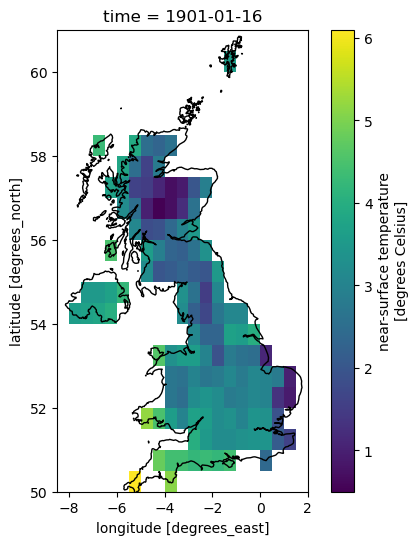

In [94]:
# Plotting time = 0 with UK boundaries
from shapely.geometry import Point

# Take one time slice just to build the spatial grid
da0 = df_uk["tmp"].isel(time=0)

# Build lon/lat mesh
lon2d, lat2d = np.meshgrid(df_uk["lon"].values, df_uk["lat"].values)

# Make points GeoDataFrame
pts = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon2d.ravel(), lat2d.ravel()),
    crs="EPSG:4326"
)

# Keep only points inside the UK polygon
inside = pts.within(uk.geometry.iloc[0]).values.reshape(lat2d.shape)

# Mask: set outside polygon to NaN
da0_masked = da0.where(inside)

fig, ax = plt.subplots(figsize=(6,6))

da0_masked.plot(ax=ax)                 # xarray draws on this Axes
uk.boundary.plot(ax=ax, color="black", linewidth=1)

plt.show()


In [12]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# function to clip raster to polygon
def clip_raster_to_geom(ax, geom, collection_index=0):
    """Clip the first QuadMesh/collection produced by xarray.plot() to a (Multi)Polygon."""
    geoms = geom.geoms if geom.geom_type == "MultiPolygon" else [geom]
    vertices, codes = [], []

    for poly in geoms:
        x, y = poly.exterior.coords.xy
        verts = np.column_stack([x, y])
        c = np.full(len(verts), Path.LINETO, dtype=np.uint8)
        c[0] = Path.MOVETO
        vertices.append(verts)
        codes.append(c)

    vertices = np.vstack(vertices)
    codes = np.concatenate(codes)

    patch = PathPatch(Path(vertices, codes), transform=ax.transData)
    ax.collections[collection_index].set_clip_path(patch)

Lon: -8.645449000271071 -0.738072999669157 Lat: 54.63919599969569 60.843381000432885


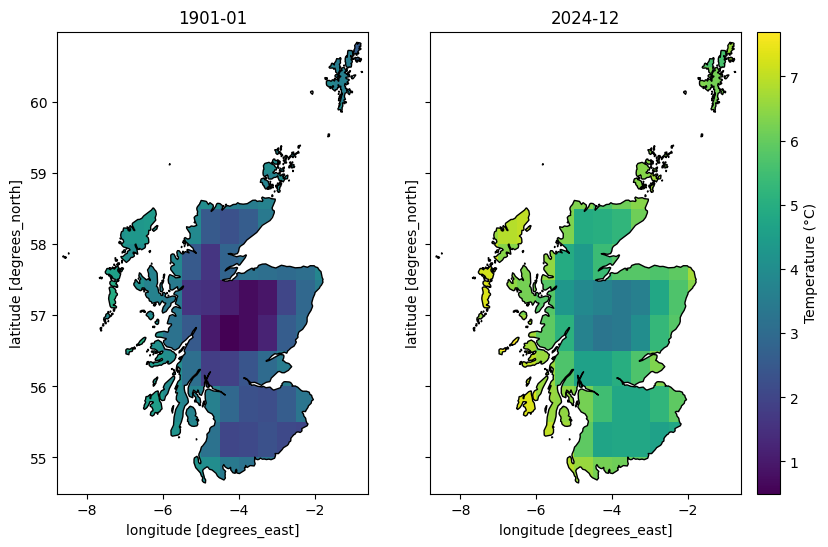

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1488, lat: 13, lon: 17)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
  * lat      (lat) float32 52B 54.75 55.25 55.75 56.25 ... 59.75 60.25 60.75
  * lon      (lon) float32 68B -8.75 -8.25 -7.75 -7.25 ... -1.75 -1.25 -0.75
Data variables:
    tmp      (time, lat, lon) float32 1MB ...
    stn      (time, lat, lon) float64 3MB ...
    mae      (time, lat, lon) float32 1MB ...
    maea     (time, lat, lon) float32 1MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    cont

In [13]:
# Scotland comparison plot (1901-01 vs 1014-12) with clipped coastline
uk_ = gpd.read_file("geoBoundaries-GBR-ADM1-all/geoBoundaries-GBR-ADM1.shp").to_crs(epsg=4326) # uk boundaries shp
scot = uk_[uk_["shapeName"] == "Scotland"].dissolve() # dissolve to single polygon

minx1, miny1, maxx1, maxy1 = scot.total_bounds
print("Lon:", minx1, maxx1, "Lat:", miny1, maxy1)
geom = scot.geometry.iloc[0]

pad = 0.15 # add some padding around the polygon to make sure we get all of it (and a bit of sea around)
minx1, maxx1 = minx1 - pad, maxx1 + pad
miny1, maxy1 = miny1 - pad, maxy1 + pad

df_scot = df.sel(lon=slice(minx1, maxx1), lat=slice(miny1, maxy1))

# pick two times
ds_0 = df_scot["tmp"].isel(time=0) # 1901-01
ds_n = df_scot["tmp"].isel(time=1487) # 2024-12

# compute shared color scale
vmin = float(min(ds_0.min(), ds_n.min()))
vmax = float(max(ds_0.max(), ds_n.max()))

# create side-by-side plots
fig, axes = plt.subplots(
    1, 2,
    figsize=(10, 6),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0.05}
)

# first plot
im0 = ds_0.plot(
    ax=axes[0],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[0].set_title("1901-01")

# second plot
im1 = ds_n.plot(
    ax=axes[1],
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False
)
axes[1].set_title("2024-12")

# clip both to Scotland
clip_raster_to_geom(axes[0], geom)
clip_raster_to_geom(axes[1], geom)

# draw boundary
scot.boundary.plot(ax=axes[0], color="black", linewidth=1)
scot.boundary.plot(ax=axes[1], color="black", linewidth=1)

# same extent
for ax in axes:
    ax.set_xlim(minx1, maxx1)
    ax.set_ylim(miny1, maxy1)

# shared colorbar
fig.colorbar(
    axes[1].collections[0],
    ax=axes,
    label="Temperature (°C)",
    fraction=0.04,
    pad=0.02
)

plt.show()

print(df_scot)

<div align="justify"> The side-by-side maps show a clear warming signal between January 1901 and December 2024 across Scotland. While the spatial structure is broadly consistent in both periods-temperatures tend to be higher in coastal grid cells and lower inland. The overall distribution in 2024 is shifted upward, indicating higher temperatures almost everywhere. </div> <br>

<div align="justify"> This combination of persistent spatial pattern (coast-inland contrast) and systematic temporal change motivates a Bayesian hierarchical spatio-temporal model that can: </div>

1. quantify the long-term warming trend,
2. separate large-scale temporal effects from local spatial variation,
3. assess whether coastal-inland differences remain stable or evolve over time.

---

#### Fitting the Model with a Bayesian Hierarchical Spatio-Temporal Model (with Seasonality)

Suppose temperature at spatial location $s$ and month $t$ is modelled as:

$$
y_{s,t} = \mu + f_{\text{space}}(s) + f_{\text{trend}}(t) + f_{\text{season}}(m_t) + f_{\text{interaction}}(s,t) + \epsilon_{s,t},
$$

where $m_t \in \{1,\dots,12\}$ denotes the month-of-year corresponding to time $t$.

Model components

- $\mu$: Global mean temperature level.

- $f_{\text{space}}(s)$: Spatial effect.  
  This captures persistent geographic variation across longitude and latitude, such as the coastal–inland contrast observed in Scotland. It is commonly modelled using a Gaussian Process (GP), often with a Matérn covariance function, to enforce spatial smoothness.

- $f_{\text{trend}}(t)$: Long-term temporal trend.  
  This represents systematic change over time (e.g., long-term warming). Depending on the specification, it may be modelled as a smooth function of time (e.g., random walk, spline, or GP) and/or include temporal dependence (e.g., AR(1)).

- $f_{\text{season}}(m_t)$: Seasonal (monthly) effect.  
  This captures the repeating annual cycle in monthly temperatures. A simple approach is to treat it as a month-of-year effect (12-level categorical term), optionally constrained to sum to zero for identifiability.

- $f_{\text{interaction}}(s,t)$: Spatio-temporal interaction effect.  
  This term allows the spatial pattern to evolve over time, enabling assessment of whether the coastal–inland contrast remains stable or changes across the study period.

- $\epsilon_{s,t}$: Observation noise.  
  This represents residual variation not explained by the spatial, trend, seasonal, or interaction components, and is typically assumed to be independent Gaussian noise with variance $\sigma^2$.

Hierarchical structure

This model is hierarchical because $f_{\text{space}}(s)$, $f_{\text{trend}}(t)$, $f_{\text{season}}(m_t)$, and $f_{\text{interaction}}(s,t)$ are treated as latent components with prior distributions. Their hyperparameters (e.g., spatial length-scale, trend smoothness or temporal correlation strength, seasonal variability, and interaction variance) are inferred from the data.

Overall, the model comprises multiple levels: (i) observed temperature measurements, (ii) latent spatial, temporal trend, seasonal, and spatio-temporal interaction components, and (iii) hyperparameters governing these components. This hierarchical structure enables joint inference on long-term warming trends, seasonal variation, persistent spatial contrasts, and potential evolution of spatial patterns over time.


##### 1️⃣ Checking whether temperature depends on time (temporal effect)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.00015660309523246596), z=np.float64(3.780357874864365), Tau=np.float64(0.0654118850829049), s=np.float64(72367.0), var_s=np.float64(366440363.6666667), slope=np.float64(0.000820591304668043), intercept=np.float64(6.9082392972455455))

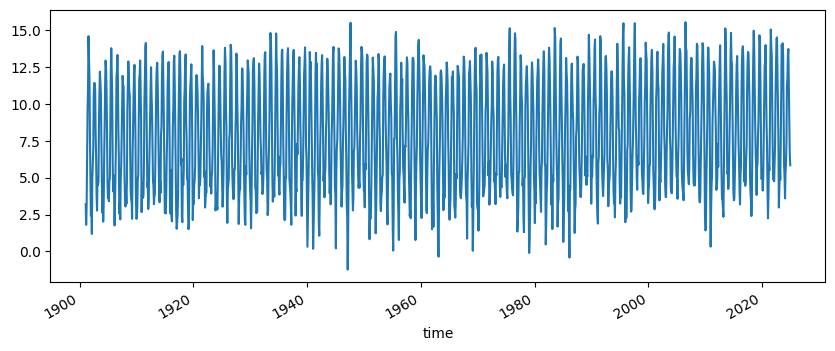

In [16]:
ts_mean = df_scot["tmp"].mean(dim=("lat","lon"))
ts = ts_mean.to_pandas()
ts.plot(figsize=(10,4))

import pymannkendall as mk
mk.original_test(ts)

The Mann–Kendall test was used to evaluate the presence of a monotonic trend in the temperature time series, supporting the modelling assumption that temperature exhibits temporal dependence. The results indicate a statistically significant monotonic trend (p = 0.00016), providing strong evidence against the null hypothesis of no temporal trend.

##### 2️⃣ Checking whether temperature depends on region (spatial effect)

In [ ]:
import numpy as np
import libpysal
from esda.moran import Moran
import matplotlib.pyplot as plt

# Generate mean temperature over time
mean_map = df_scot["tmp"].mean(dim="time")

# latten temperature values and matching lon/lat grid
mean_temp = mean_map.values.flatten()
lon2d, lat2d = np.meshgrid(df_scot["lon"].values, df_scot["lat"].values)
coords = np.column_stack([lon2d.flatten(), lat2d.flatten()])

# Remove NaN 
mask = np.isfinite(mean_temp)          # keeps only non-NaN 
mean_temp_clean = mean_temp[mask]
coords_clean = coords[mask]

# Construct spatial weights
w = libpysal.weights.KNN.from_array(coords_clean, k=8)
w.transform = "r"

# Calculate Moran's I
mi = Moran(mean_temp_clean, w)

print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)
print("Number of locations used:", len(mean_temp_clean))

Moran's I: 0.5558532640359362
p-value: 0.001
Number of locations used: 109


Moran’s I was computed to assess spatial autocorrelation in the mean temperature map across Scotland. The statistic was 0.556 (p = 0.001), indicating strong and statistically significant positive spatial autocorrelation. This suggests that nearby grid cells exhibit similar temperature levels, confirming the presence of spatial clustering. These findings justify the inclusion of a spatial random effect in the hierarchical spatio-temporal model.

#### Checking whether temperature depends on seasonal effect